## Import statements

In [2]:
# Import required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from scipy.spatial.distance import cdist

random.seed(123)

## Function definitions

In [3]:
# Normalize edges to handle undirected graphs
def normalize_edges(df):
    df["Source"], df["Target"] = zip(*df[["Source", "Target"]].apply(lambda x: sorted(x), axis=1))
    return df

## Perform analysis

In [4]:
# Node map
node_categories_path = "/Users/vsriram/Desktop/GxS/ddnComp_personalComputer/traitDescription_diseaseCategories.csv"
node_categories = pd.read_csv(node_categories_path, sep=",")[['Id', 'Disease Category']].set_index('Id')['Disease Category'].to_dict()

In [5]:
# Import male and female networks
f_file_path = "/Users/vsriram/Desktop/GxS/ddnComp_personalComputer/ddnsForDDNComp/ssDDNneg4_femaleBlock_edgeMap.tsv"
f_edges_df = normalize_edges(pd.read_csv(f_file_path, sep="\t").iloc[:, :3])
f_edges_df['Weight'] = pd.to_numeric(f_edges_df['Weight'], errors='coerce')


m_file_path = "/Users/vsriram/Desktop/GxS/ddnComp_personalComputer/ddnsForDDNComp/ssDDNneg4_maleBlock_edgeMap.tsv"
m_edges_df = normalize_edges(pd.read_csv(m_file_path, sep="\t").iloc[:, :3])
m_edges_df['Weight'] = pd.to_numeric(m_edges_df['Weight'], errors='coerce')

In [6]:
f_node_labels = list(set(f_edges_df['Source']).union(set(f_edges_df['Target'])))
m_node_labels = list(set(m_edges_df['Source']).union(set(m_edges_df['Target'])))

In [7]:
m_edges_df['source_category'] = m_edges_df['Source'].map(node_categories)
m_edges_df['target_category'] = m_edges_df['Target'].map(node_categories)

f_edges_df['source_category'] = f_edges_df['Source'].map(node_categories)
f_edges_df['target_category'] = f_edges_df['Target'].map(node_categories)

In [8]:
grouped_f = f_edges_df.groupby(["source_category", "target_category"]).size().reset_index(name="Count")
grouped_m = m_edges_df.groupby(["source_category", "target_category"]).size().reset_index(name="Count")

In [9]:
pivot_f = grouped_f.pivot(index="source_category", columns="target_category", values="Count").fillna(0)
pivot_m = grouped_m.pivot(index="source_category", columns="target_category", values="Count").fillna(0)

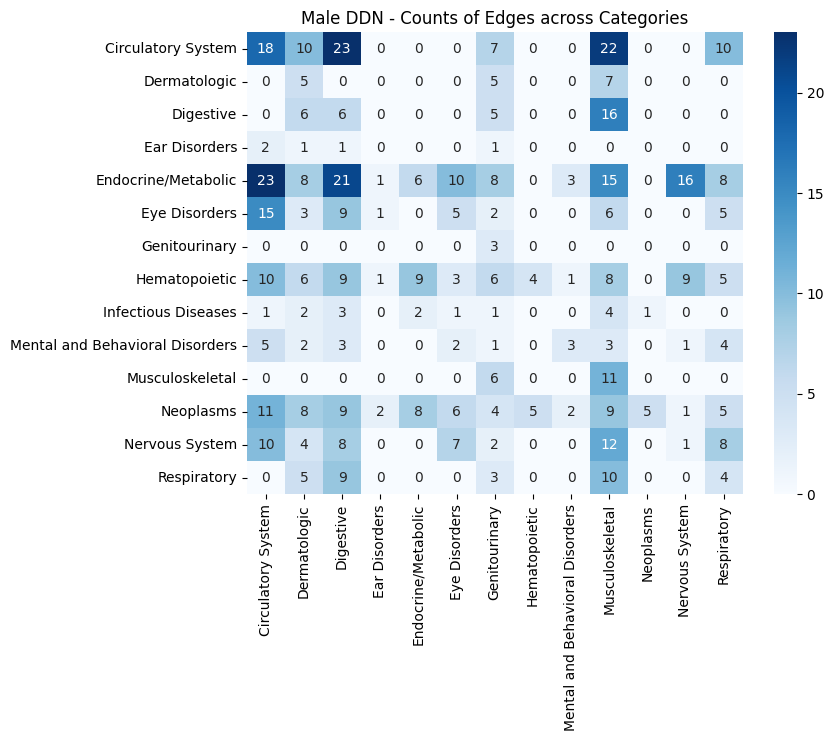

In [ ]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_m, annot=True, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True))
plt.title("Male DDN - Counts of Edges across Categories")
plt.xlabel("")
plt.ylabel("")
plt.show()

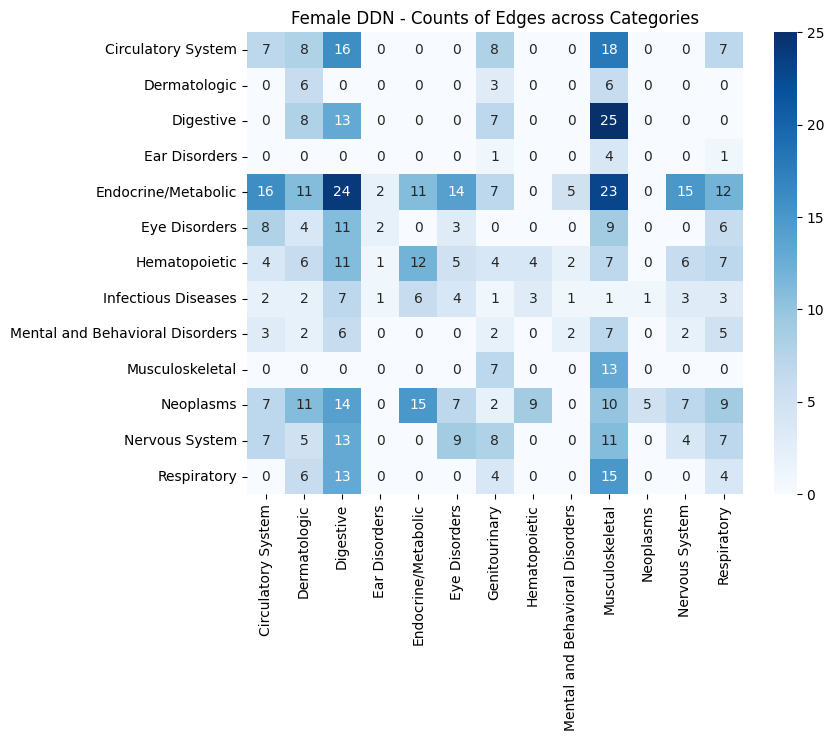

In [ ]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_f, annot=True, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True))
plt.title("Female DDN - Counts of Edges across Categories")
plt.xlabel("")
plt.ylabel("")
plt.show()

In [15]:
# Get common edges across the two networks and show them in a single heatmap
# Columns to match on
columns_to_match = ["Source", "Target", "source_category", "target_category"]

# Find intersection based on these columns
intersection = pd.merge(m_edges_df, f_edges_df, on=columns_to_match, how="inner")


In [16]:
grouped_intersection = intersection.groupby(["source_category", "target_category"]).size().reset_index(name="Count")

In [17]:
pivot_intersection = grouped_intersection.pivot(index="source_category", columns="target_category", values="Count").fillna(0)

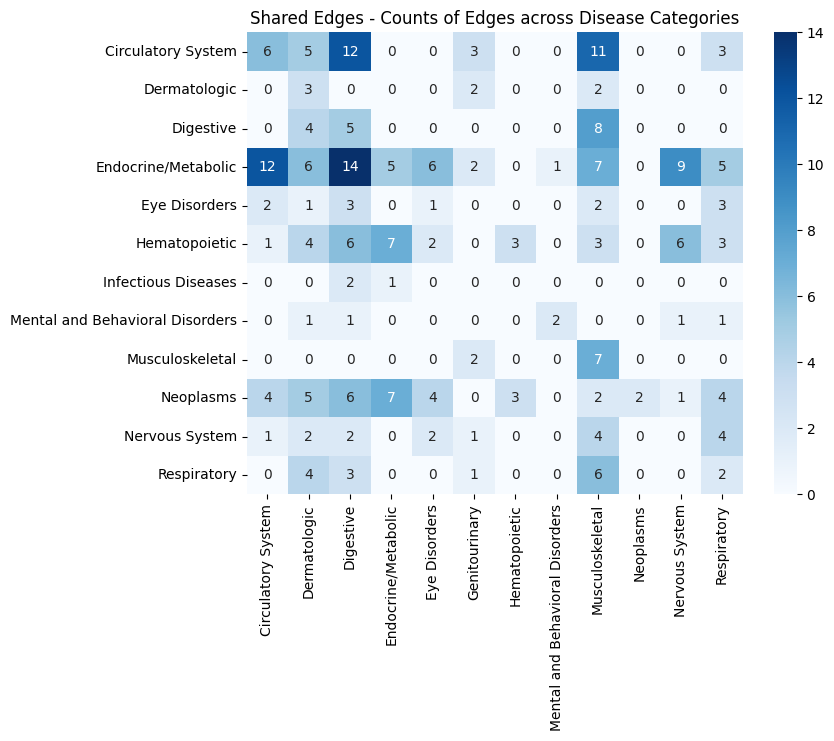

In [ ]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_intersection, annot=True, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True))
plt.title("Shared Edges - Counts of Edges across Disease Categories")
plt.xlabel("")
plt.ylabel("")
plt.show()

In [20]:
# Normalize the edge weights to between 0 and 1
#math.log(intersection['Weight_x']+1)
intersection['Weight_x_log'] = np.log(intersection['Weight_x']+1)
intersection['Weight_y_log'] = np.log(intersection['Weight_y']+1)

# Determine correlation in edge weights for shared edges

In [21]:
# Using corrcoef()
correlation_matrix = np.corrcoef(
    intersection['Weight_x_log'], 
    intersection['Weight_y_log']
)

correlation_coefficient = correlation_matrix[0, 1]

print(correlation_coefficient)

0.585591889472889


# Embedding visualizations

In [22]:
embedding_mat_m_full = pd.read_csv("/Users/vsriram/Desktop/GxS/ddnComp_personalComputer/embeddingMat_m.csv").iloc[:, 1:20]
embedding_mat_m_data = embedding_mat_m_full.iloc[:, 1:17]

embedding_mat_f_full = pd.read_csv("/Users/vsriram/Desktop/GxS/ddnComp_personalComputer/embeddingMat_f.csv").iloc[:, 1:20]
embedding_mat_f_data = embedding_mat_f_full.iloc[:, 1:17]

In [23]:

embedding_matrix_m_np = embedding_mat_m_data.to_numpy()
embedding_matrix_f_np = embedding_mat_f_data.to_numpy()

In [24]:
distances_m_np = cdist(embedding_matrix_m_np, embedding_matrix_m_np, metric='cosine')
distances_m_pd = pd.DataFrame(distances_m_np, columns = embedding_mat_m_full['Trait'])
distances_m_pd.index = embedding_mat_m_full['Trait']

distances_f_np = cdist(embedding_matrix_f_np, embedding_matrix_f_np, metric='cosine')
distances_f_pd = pd.DataFrame(distances_f_np, columns = embedding_mat_f_full['Trait'])
distances_f_pd.index = embedding_mat_f_full['Trait']

In [25]:
meanEmbeddingDistances_m = distances_m_pd.mean().sort_values()
meanEmbeddingDistances_f = distances_f_pd.mean().sort_values()

In [26]:
#Get the 50 most central diseases on average
mostCentralDiseases_m = set(meanEmbeddingDistances_m[0:30].index)
mostCentralDiseases_f = set(meanEmbeddingDistances_f[0:30].index)

mostCentralDiseases = mostCentralDiseases_m.intersection(mostCentralDiseases_f)
len(mostCentralDiseases)

9

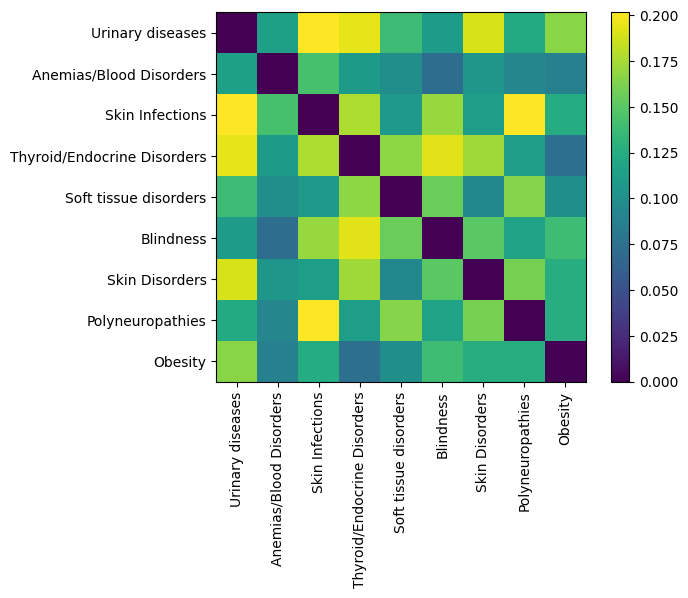

In [27]:
distances_m_pd_centralDiseases = distances_m_pd.copy()
distances_m_pd_centralDiseases = distances_m_pd_centralDiseases[distances_m_pd_centralDiseases.columns.intersection(mostCentralDiseases)]

maleDiseasesToDrop = list(set(embedding_mat_m_full['Trait']) - set(mostCentralDiseases))
for elem in maleDiseasesToDrop:
    distances_m_pd_centralDiseases = distances_m_pd_centralDiseases.drop(elem)

mostCentralDiseaseNames = ['Urinary diseases', 'Anemias/Blood Disorders', 'Skin Infections', 'Thyroid/Endocrine Disorders', 'Soft tissue disorders', 'Blindness', 'Skin Disorders', 'Polyneuropathies', 'Obesity']
fig, ax = plt.subplots()
im = ax.imshow(distances_m_pd_centralDiseases)

ax.set_xticks(np.arange(len(mostCentralDiseases)))
ax.set_xticklabels(mostCentralDiseaseNames, rotation = 90)
ax.set_yticks(np.arange(len(mostCentralDiseases)))
ax.set_yticklabels(mostCentralDiseaseNames)

cbar = ax.figure.colorbar(im, ax = ax)

plt.show()

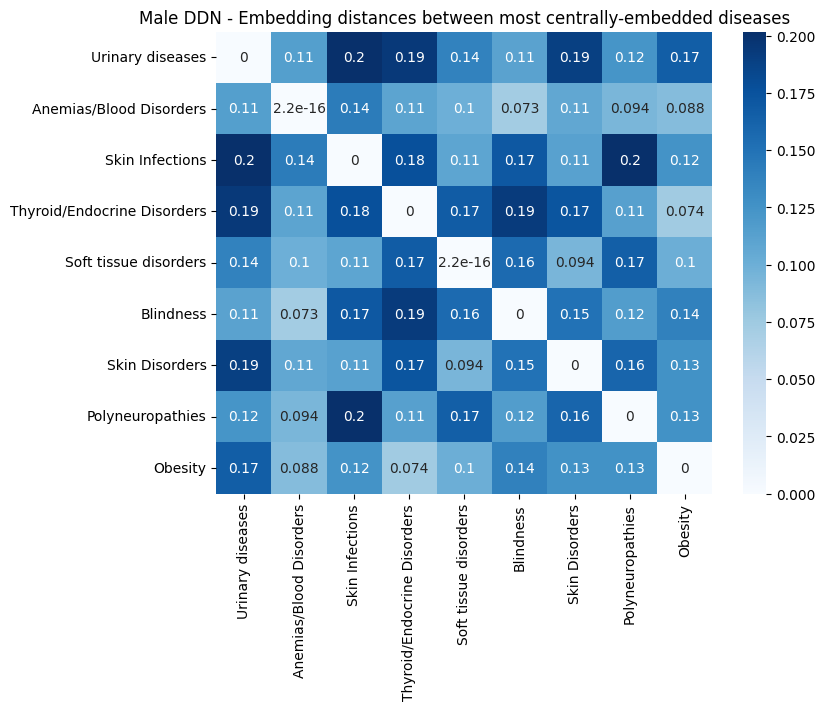

In [ ]:
# Plot the heatmap
mostCentralDiseaseNames = ['Urinary diseases', 'Anemias/Blood Disorders', 'Skin Infections', 'Thyroid/Endocrine Disorders', 'Soft tissue disorders', 'Blindness', 'Skin Disorders', 'Polyneuropathies', 'Obesity']

plt.figure(figsize=(8, 6))
sns.heatmap(distances_m_pd_centralDiseases, 
            annot=True, 
            fmt=".2g", 
            cmap=sns.color_palette("Blues", as_cmap=True),
            xticklabels=mostCentralDiseaseNames,
            yticklabels=mostCentralDiseaseNames)
plt.title("Male DDN - Embedding distances between most centrally-embedded diseases")
plt.xlabel("")
plt.ylabel("")
plt.show()

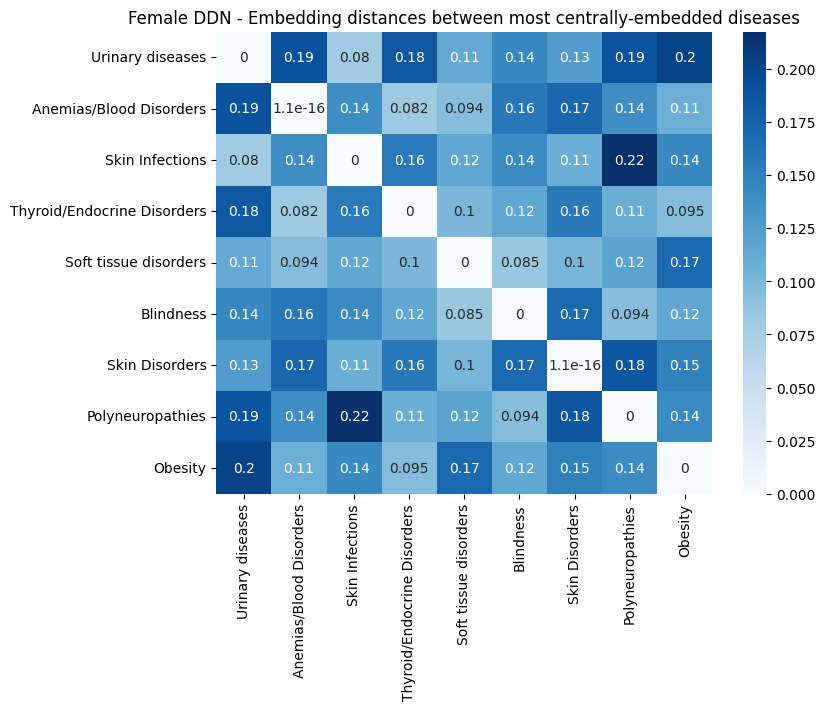

In [30]:
distances_f_pd_centralDiseases = distances_f_pd.copy()
distances_f_pd_centralDiseases = distances_f_pd_centralDiseases[distances_f_pd_centralDiseases.columns.intersection(mostCentralDiseases)]

femaleDiseasesToDrop = list(set(embedding_mat_f_full['Trait']) - set(mostCentralDiseases))
for elem in femaleDiseasesToDrop:
    distances_f_pd_centralDiseases = distances_f_pd_centralDiseases.drop(elem)

plt.figure(figsize=(8, 6))
sns.heatmap(distances_f_pd_centralDiseases, 
            annot=True, 
            fmt=".2g", 
            cmap=sns.color_palette("Blues", as_cmap=True),
            xticklabels=mostCentralDiseaseNames,
            yticklabels=mostCentralDiseaseNames)
plt.title("Female DDN - Embedding distances between most centrally-embedded diseases")
plt.xlabel("")
plt.ylabel("")
plt.show()

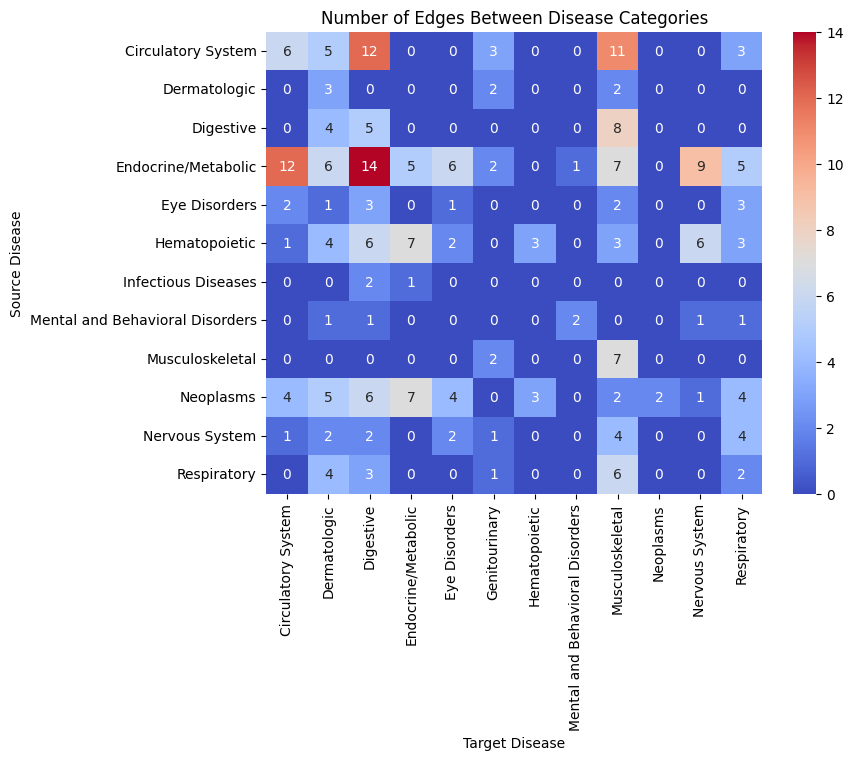

In [ ]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_intersection, annot=True, fmt=".0f", cmap="coolwarm")
plt.title("Number of Edges Between Disease Categories")
plt.xlabel("Target Disease")
plt.ylabel("Source Disease")
plt.show()